In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import parallel_where_binary, Aligner4

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

from metadata import *

Setting environment for Gordon


In [2]:
stack_fixed = 'MD589'
stack_moving = 'MD594'

In [3]:
volume_fixed = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_down32_annotationVolume.bp' % {'stack': stack_fixed}))
volume_moving = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_down32_annotationVolume.bp' % {'stack': stack_moving}))
print volume_fixed.shape
print volume_moving.shape

(348, 421, 377)
(326, 515, 368)


In [4]:
label_to_name_fixed = {}
name_to_label_fixed = {}

with open(os.path.join(volume_dir, stack_fixed, stack_fixed+'_down32_annotationVolume_nameToLabel.txt'), 'r') as f:
    for line in f.readlines():
        name_s, label = line.split()
        label_to_name_fixed[int(label)] = name_s
        name_to_label_fixed[name_s] = int(label)
        
with open(os.path.join(volume_dir, stack_fixed, stack_fixed+'_down32_annotationVolume_bbox.txt'), 'r') as f:
    vol_fixed_xmin, vol_fixed_xmax, vol_fixed_ymin, vol_fixed_ymax, vol_fixed_zmin, vol_fixed_zmax = map(int, f.readline().strip().split())

In [5]:
label_to_name_moving = {}
name_to_label_moving = {}

with open(os.path.join(volume_dir, stack_moving, stack_moving+'_down32_annotationVolume_nameToLabel.txt'), 'r') as f:
    for line in f.readlines():
        name_s, label = line.split()
        label_to_name_moving[int(label)] = name_s
        name_to_label_moving[name_s] = int(label)
        
with open(os.path.join(volume_dir, stack_moving, stack_moving+'_down32_annotationVolume_bbox.txt'), 'r') as f:
    vol_moving_xmin, vol_moving_xmax, vol_moving_ymin, vol_moving_ymax, vol_moving_zmin, vol_moving_zmax = map(int, f.readline().strip().split())

In [6]:
labelIndexMap_m2f = {}
for label_m, name_m in label_to_name_moving.iteritems():
    labelIndexMap_m2f[label_m] = name_to_label_fixed[name_m]

In [7]:
# aligner = Alizgner4(volume_fixed, volume_moving, labelIndexMap_m2f={37:37, 36:36})

In [8]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=labelIndexMap_m2f)

In [9]:
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[name_to_label_moving['SNR_R']])

In [10]:
gradient_filepath_map_f = {ind_f: volume_dir + '/%(stack)s/gradients/%(stack)s_down32_annotationVolume_%(label)s_%%(suffix)s.bp' % \
                           {'stack': stack_fixed, 'label': label_to_name_fixed[ind_f]}
                           for ind_m, ind_f in labelIndexMap_m2f.iteritems()}

In [11]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f, indices_f=None)

load gradient 1: 0.324104 seconds
load gradient 2: 0.322172 seconds
load gradient 3: 0.463556 seconds
load gradient 4: 0.446181 seconds
load gradient 5: 0.354535 seconds
load gradient 6: 0.328675 seconds
load gradient 7: 0.337708 seconds
load gradient 8: 0.345296 seconds
load gradient 9: 0.391006 seconds
load gradient 10: 0.335618 seconds
load gradient 11: 0.329814 seconds
load gradient 12: 0.306679 seconds
load gradient 13: 0.375108 seconds
load gradient 14: 0.331948 seconds
load gradient 15: 0.333031 seconds
load gradient 16: 0.381058 seconds
load gradient 17: 0.423382 seconds
load gradient 18: 0.387658 seconds
load gradient 19: 0.480414 seconds
load gradient 20: 0.411454 seconds
load gradient 21: 0.379928 seconds
load gradient 22: 0.259766 seconds
load gradient 23: 0.306557 seconds
load gradient 24: 0.284285 seconds
load gradient 25: 0.310948 seconds
load gradient 26: 0.318510 seconds
load gradient 27: 0.316717 seconds
load gradient 28: 0.312995 seconds
load gradient 29: 0.299808 se

In [ ]:
# aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f, indices_f=[name_to_label_fixed['5N_L'],
#                                                                                  name_to_label_fixed['5N_R'],
#                                                                                  name_to_label_fixed['12N'],
#                                                                                   name_to_label_fixed['SNR_L'],
#                                        name_to_label_fixed['SNR_R']])

In [ ]:
# aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f, indices_f=[name_to_label_fixed['SNR_L']])

In [ ]:
# T, scores = aligner.optimize(type='rigid', max_iter_num=10, history_len=500, terminate_thresh=1e-4,
#                              grid_search_sample_number=1000,
#                              indices_m=None)

In [ ]:
# T, scores = aligner.optimize(type='rigid', max_iter_num=20, history_len=500, terminate_thresh=1e-4,
#                              indices_m=[name_to_label_moving['5N_L'],
#                                         name_to_label_moving['5N_R'],
#                                        name_to_label_fixed['12N'],
#                                        name_to_label_fixed['SNR_L'],
#                                        name_to_label_fixed['SNR_R']])

In [14]:
# largely the same optimization path regardless of the starting condition

# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

T, scores = aligner.optimize(type='rigid', max_iter_num=1000, history_len=500, terminate_thresh=1e-4,
#                              indices_m=[name_to_label_fixed['SNR_L']],
                             indices_m=None,
                            grid_search_iteration_number=10,
                             grid_search_sample_number=100,
                             grad_computation_sample_number=1e5,
                             lr1=10., lr2=.1)
#                              init_T=[1,0,0,-10,0,1,0,0,0,0,1,0])

grid search: 2.908054 seconds
0.000000 1.406241
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transf

[[  9.37209771e-01  -3.47865972e-01   2.50421977e-02   3.50770693e+01]
 [  3.48413665e-01   9.37073372e-01  -2.23922698e-02   2.91192870e+01]
 [ -1.56768679e-02   2.97112979e-02   9.99435578e-01  -2.21067751e+00]]
2.48011682954 2.32316579063


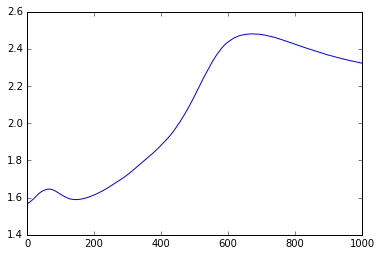

In [15]:
print T.reshape((3,4))
plt.plot(scores);
print max(scores), scores[-1]

In [14]:
atlasAlignParams_dir = create_if_not_exists(atlasAlignParams_rootdir + '/%(stack_moving)s_to_%(stack_fixed)s' % \
                     {'stack_moving': stack_moving, 'stack_fixed': stack_fixed})

In [ ]:
with open(atlasAlignParams_dir + '/%(stack_moving)s_down32_annotationVolume_to_%(stack_fixed)s_down32_annotationVolume_parameters.txt' % \
          {'stack_moving': stack_moving, 'stack_fixed': stack_fixed}, 'w') as f:
    
    f.write(array_to_one_liner(T))
    f.write(array_to_one_liner(aligner.centroid_m))
    f.write(array_to_one_liner([aligner.xdim_m, aligner.ydim_m, aligner.zdim_m]))
    f.write(array_to_one_liner(aligner.centroid_f))
    f.write(array_to_one_liner([aligner.xdim_f, aligner.ydim_f, aligner.zdim_f]))

In [ ]:
# Try all sets of parameters 

grid search: 2.804557 seconds
0.000000 1.468269
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transform.
No valid voxels after transf

NameError: name 'atlasAlignParams_dir' is not defined

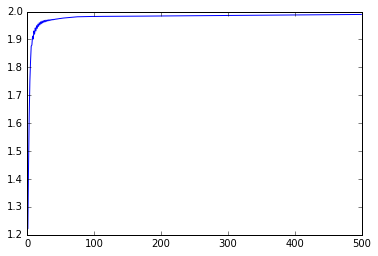

In [13]:
c = 0

for lr1 in [.1, 1., 10.]:
    for lr2 in [1e-1, 1e-2, 1e-3]:
        for n in [1e3, 1e4, 1e5]:
            
            
            c += 1
        
            T, scores = aligner.optimize(type='affine', max_iter_num=500, history_len=500, terminate_thresh=1e-4,
            #                              indices_m=[name_to_label_fixed['SNR_L']],
                                         indices_m=None,
                                        grid_search_iteration_number=10,
                                         grid_search_sample_number=100,
                                         grad_computation_sample_number=n,
                                         lr1=lr1, lr2=lr2)
            #                              init_T=[1,0,0,-10,0,1,0,0,0,0,1,0])
            
            plt.figure();
            plt.plot(scores);
            plt.savefig(atlasAlignParams_dir + '/affine/%(stack_moving)s_to_%(stack_fixed)s_scoreEvolution_%(c)d.png' % \
                        {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'c':c},
                        bbox_inches='tight')
            
            with open(atlasAlignParams_dir + '/affine/%(stack_moving)s_to_%(stack_fixed)s_scoreEvolution_%(c)d.txt' % \
                       {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'c':c}, 'w') as f:
                f.write(array_to_one_liner([lr1, lr2, n]))
#             print max(scores), scores[-1]

In [13]:
c = 0
for lr1 in [.1, 1., 10.]:
    for lr2 in [1e-1, 1e-2, 1e-3]:
        for n in [1e3, 1e4, 1e5]:
            c += 1
            print c, lr1, lr2, int(n)

1 0.1 0.1 1000
2 0.1 0.1 10000
3 0.1 0.1 100000
4 0.1 0.01 1000
5 0.1 0.01 10000
6 0.1 0.01 100000
7 0.1 0.001 1000
8 0.1 0.001 10000
9 0.1 0.001 100000
10 1.0 0.1 1000
11 1.0 0.1 10000
12 1.0 0.1 100000
13 1.0 0.01 1000
14 1.0 0.01 10000
15 1.0 0.01 100000
16 1.0 0.001 1000
17 1.0 0.001 10000
18 1.0 0.001 100000
19 10.0 0.1 1000
20 10.0 0.1 10000
21 10.0 0.1 100000
22 10.0 0.01 1000
23 10.0 0.01 10000
24 10.0 0.01 100000
25 10.0 0.001 1000
26 10.0 0.001 10000
27 10.0 0.001 100000


In [ ]:
# READ

In [ ]:
stack_fixed = 'MD589'
stack_moving = 'MD594'

In [ ]:
atlasAlignParams_dir = create_if_not_exists(atlasAlignParams_rootdir + '/%(stack_moving)s_to_%(stack_fixed)s' % \
                     {'stack_moving': stack_moving, 'stack_fixed': stack_fixed})

In [ ]:
volume_fixed = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_down32_annotationVolume.bp' % {'stack': stack_fixed}))
volume_moving = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_down32_annotationVolume.bp' % {'stack': stack_moving}))
print volume_fixed.shape
print volume_moving.shape

In [ ]:
# stack = 'MD589'

with open(atlasAlignParams_dir + '/%(stack_moving)s_down32_annotationVolume_to_%(stack_fixed)s_down32_annotationVolume_parameters.txt' % \
          {'stack_moving': stack_moving, 'stack_fixed': stack_fixed}, 'r') as f:
    
    lines = f.readlines()
    
    global_params = one_liner_to_arr(lines[0], float)
    centroid_m = one_liner_to_arr(lines[1], float)
    xdim_m, ydim_m, zdim_m  = one_liner_to_arr(lines[2], int)
    centroid_f = one_liner_to_arr(lines[3], float)
    xdim_f, ydim_f, zdim_f  = one_liner_to_arr(lines[4], int)

In [ ]:
all_indices_m = set(np.unique(volume_moving)) - {0}

In [ ]:
nzvoxels_m = {i: parallel_where_binary(volume_moving==i) for i in all_indices_m}

In [ ]:
# HANGS for some reason
# from multiprocessing import Pool

# pool = Pool(2)
# # nzvoxels_m_ = pool.map(lambda i: parallel_where_binary(volume_m[i] > 0, num_samples=int(1e6)),
# #                         self.all_indices_m)
# nzvoxels_m = pool.map(lambda i: parallel_where_binary(volume_moving==i),
#                         all_indices_m)
# pool.close()
# pool.join()

# nzvoxels_m = dict(zip(all_indices_m, nzvoxels_m))

In [ ]:
from registration_utilities import transform_points

In [ ]:
nzs_m_aligned_to_f = {ind_m: transform_points(global_params, pts=nzs_m, 
                                              c=centroid_m, c_prime=centroid_f).astype(np.int16)
                      for ind_m, nzs_m in nzvoxels_m.iteritems()}

volume_m_aligned_to_f = np.zeros((ydim_f, xdim_f, zdim_f), np.int)

for ind_m in nzs_m_aligned_to_f.iterkeys():

    xs_f, ys_f, zs_f = nzs_m_aligned_to_f[ind_m].T
    
    valid = (xs_f >= 0) & (ys_f >= 0) & (zs_f >= 0) & \
    (xs_f < xdim_f) & (ys_f < ydim_f) & (zs_f < zdim_f)

    xs_m, ys_m, zs_m = nzvoxels_m[ind_m].T
    
    volume_m_aligned_to_f[ys_f[valid], xs_f[valid], zs_f[valid]] = \
    volume_moving[ys_m[valid], xs_m[valid], zs_m[valid]]

del nzs_m_aligned_to_f

In [ ]:
filename_to_section = {}
section_to_filename = {}
with open('/home/yuncong/CSHL_data_processed/%(stack_fixed)s/%(stack_fixed)s_sorted_filenames.txt' %\
          dict(stack_fixed=stack_fixed), 'r') as f:
    for line in f.readlines():
        fn, label = line.strip().split()
        filename_to_section[fn] = int(label)
        section_to_filename[int(label)] = fn

In [ ]:
with open('/home/yuncong/csd395/CSHL_volumes2/%(stack_fixed)s/%(stack_fixed)s_down32_annotationVolume_bbox.txt' %\
          dict(stack_fixed=stack_fixed), 'r') as f:
    xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = map(int, f.readline().strip().split())
    print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

In [ ]:
# with open('/home/yuncong/CSHL_data_processed/%(stack_fixed)s/%(stack_fixed)s_cropbox.txt' %\
#           dict(stack_fixed=stack_fixed), 'r') as f:
#     xmin, xmax, ymin, ymax, sec_min, sec_max = map(int, f.readline().strip().split())
#     print xmin, xmax, ymin, ymax, sec_min, sec_max

In [ ]:
# volume_tb_fixed = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_volumes2/%(stack_fixed)s/%(stack_fixed)s_down32Volume.bp' % dict(stack_fixed=stack_fixed))

In [ ]:
from registration_utilities import find_contour_points

In [ ]:
downsample_factor = 32
xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
voxel_z_size = section_thickness / xy_pixel_distance_downsampled

In [ ]:
create_if_not_exists(os.path.join(atlasAlignParams_dir, 'viz'))

In [ ]:
bar = show_progress_bar(100, 300)

for sec in range(100, 300):
    
    if section_to_filename[sec] in ['Placeholder', 'Rescan', 'Nonexisting']:
        continue
    
    bar.value = sec

    z = voxel_z_size * (sec - 1) - zmin_vol_f

    contours_f_on_volume = find_contour_points(volume_fixed[..., int(z)])
    contours_f_on_cropped = {i: [cnt + (xmin_vol_f, ymin_vol_f) for cnt in cnts] for i, cnts in contours_f_on_volume.iteritems()}

    contours_m_alignedTo_f_on_volume = find_contour_points(volume_m_aligned_to_f[..., int(z)])
    contours_m_alignedTo_f_on_cropped = {i: [cnt + (xmin_vol_f, ymin_vol_f) for cnt in cnts] for i, cnts in contours_m_alignedTo_f_on_volume.iteritems()}

    img = imread('/home/yuncong/CSHL_data_processed/%(stack_fixed)s/%(stack_fixed)s_thumbnail_sorted_aligned/%(stack_fixed)s_%(sec)04d_thumbnail_aligned.tif' %\
               dict(stack_fixed=stack_fixed, sec=sec))


    viz = img.copy()

    for ind_m, cnts_m in contours_m_alignedTo_f_on_cropped.iteritems():
        for cnt_m in cnts_m:
            cv2.polylines(viz, [cnt_m.astype(np.int)], True, (255,0,0), 2)

    for ind_f, cnts_f in contours_f_on_cropped.iteritems():
        for cnt_f in cnts_f:
            cv2.polylines(viz, [cnt_f.astype(np.int)], True, (0,255,0), 2)


#     plt.figure(figsize=(20,20));
#     plt.imshow(viz[:800, :1200])
#     plt.show();
    
    viz_fn = os.path.join(atlasAlignParams_dir, 'viz', '%(stack_moving)s_to_%(stack_fixed)s_%(sec)04d.jpg' % \
          {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'sec': sec})
    imsave(viz_fn, viz[:800, :1200])

In [ ]:
volume_m_alignedTo_f_fn = os.path.join(atlasAlignParams_dir, '%(stack_moving)s_down32_annotationVolume_alignedTo_%(stack_fixed)s_down32_annotationVolume.bp' % \
                                       {'stack_moving': stack_moving, 'stack_fixed': stack_fixed})

In [ ]:
from annotation_utilities import fill_sparse_volume
volume_m_aligned_to_f_densified = fill_sparse_volume(volume_m_aligned_to_f)

In [ ]:
bp.pack_ndarray_file(volume_m_aligned_to_f_densified, volume_m_alignedTo_f_fn)

In [ ]:
# def visualize_cross_section(volume_f, aligned_volume_m, z_f, m_style='contour', f_style='contour'):
    
    
    
    